# Effect of spectral resolution on refractive layer transmission
In notebook 0 we showed that the output of a multilayer optical calculation performed with Windt's (IDL) IMD software and Byrnes' (python) TMM package gave the same result. We also converted Windt's method for introducing an instrument spectral resolution into python script. In this notebook we show the explicit effect of reducing the spectral resolution of the simulation output.

In [7]:
import funcs

import numpy as np
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

deg = np.pi/180. # conversion factor degrees to radians

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
nkDir     = workDir+'nk/'
datapath  = 'data/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'

In [3]:
# initialize wavelength scale and refractive indeces
wav = {'1A':np.linspace(4.8,5.8,10000),'1B':np.linspace(5.6,6.7,10000)}
n_ZnS,n_Si,n_BE,n_SiAs,n_Al = [{} for i in range(5)]
for band in wav.keys():
    n_ZnS[band]  = funcs.indexOfRefractionZnS(wav[band])
    n_Si[band]   = funcs.indexOfRefractionSi(wav[band])
    n_BE[band]   = funcs.indexOfRefractionBE(wav[band])
    n_SiAs[band] = funcs.indexOfRefractionSiAs(wav[band])
    n_Al[band] = funcs.indexOfRefractionAl(wav[band])

<IPython.core.display.Javascript object>


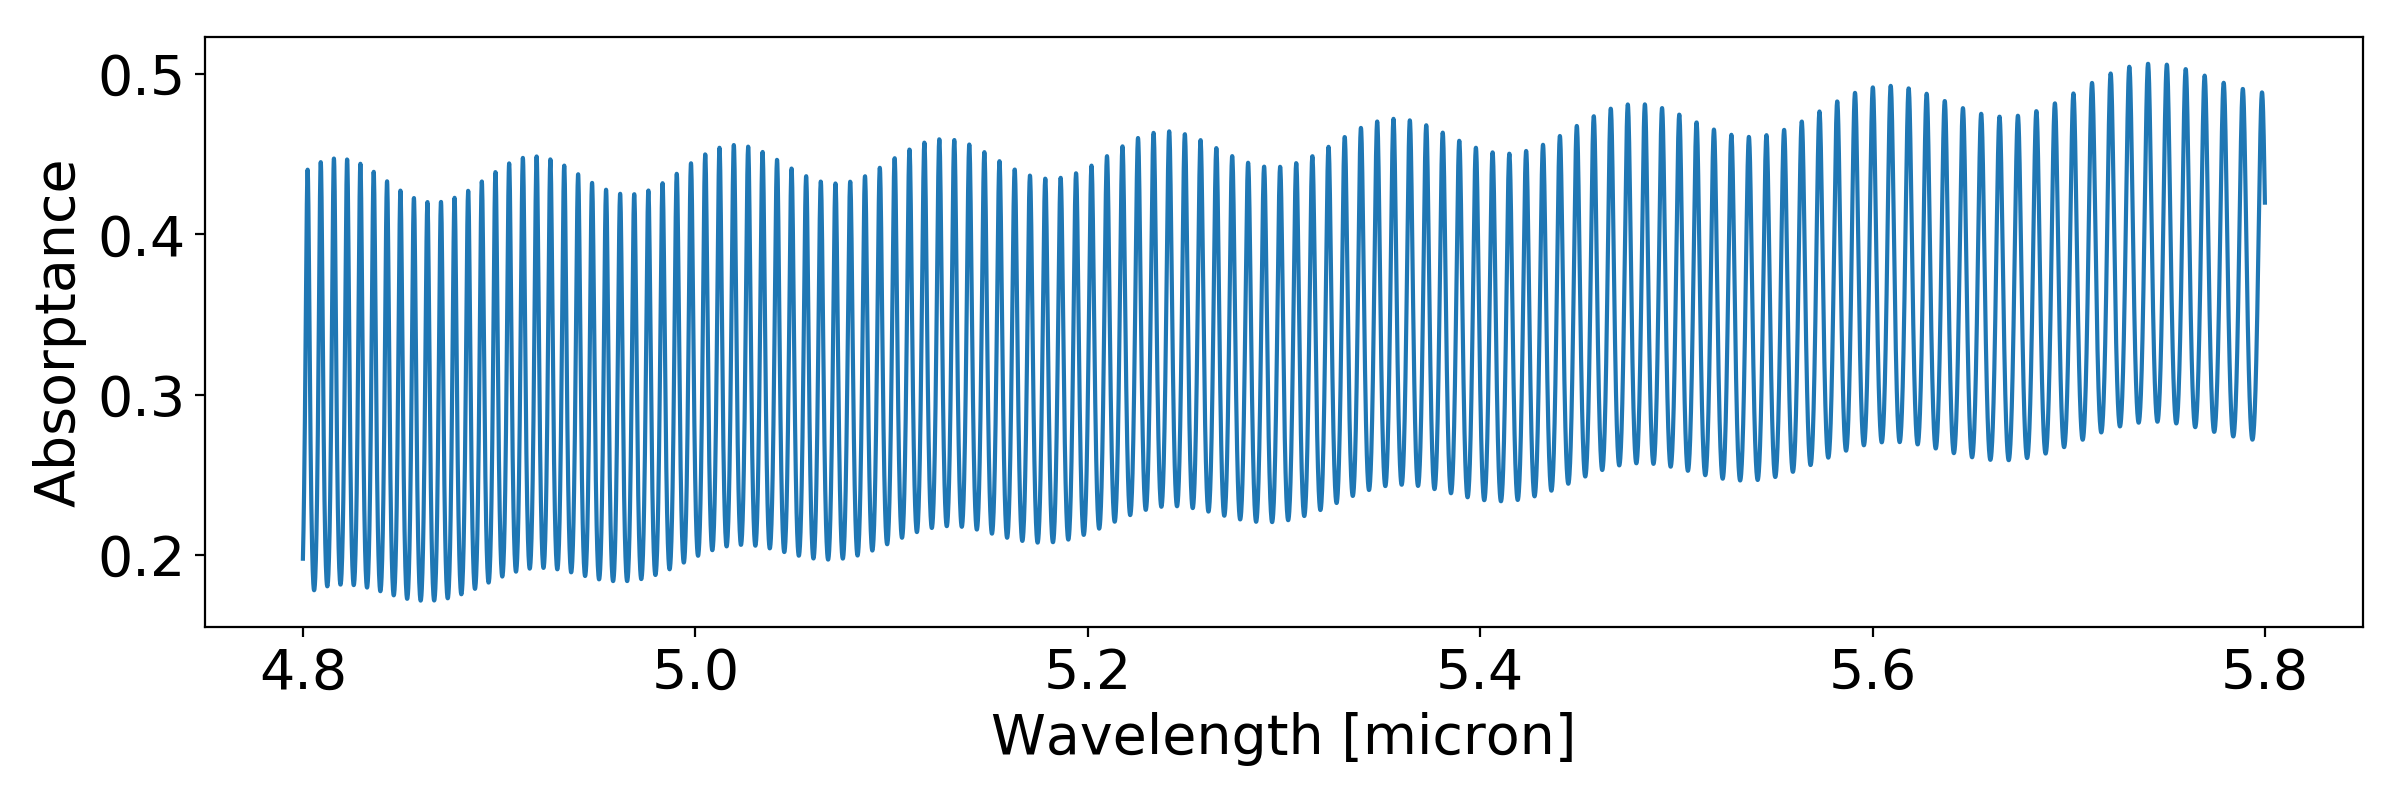

In [17]:
Refl,Transm,Absorp = {},{},{}
for band in ['1A']:
    Refl[band],Transm[band],Absorp[band] = [np.zeros(len(wav[band])) for i in range(3)]
    for i,wvl in enumerate(wav[band]):
        # define stack of refractive layers
        n_list = [1,n_ZnS[band][i],n_Si[band][i],n_BE[band][i],n_SiAs[band][i], n_Al[band][i]] # refractive index
        d_list = [np.inf, 0.65e3,465e3,0.01e3,35e3, np.inf] # thickness, nanometers
        lambda_vac = wvl*1000 # convert microns to nanometers
        # solve the Fresnel equations using the Transfer-Matrix Method
        Refl[band][i],Transm[band][i],Absorp[band][i] =  funcs.simple_tmm(n_list, d_list, 0*deg, lambda_vac)

plt.figure(figsize=(12,4))
plt.plot(wav[band],Absorp[band])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Absorptance')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

### MRS spectral resolution

<IPython.core.display.Javascript object>


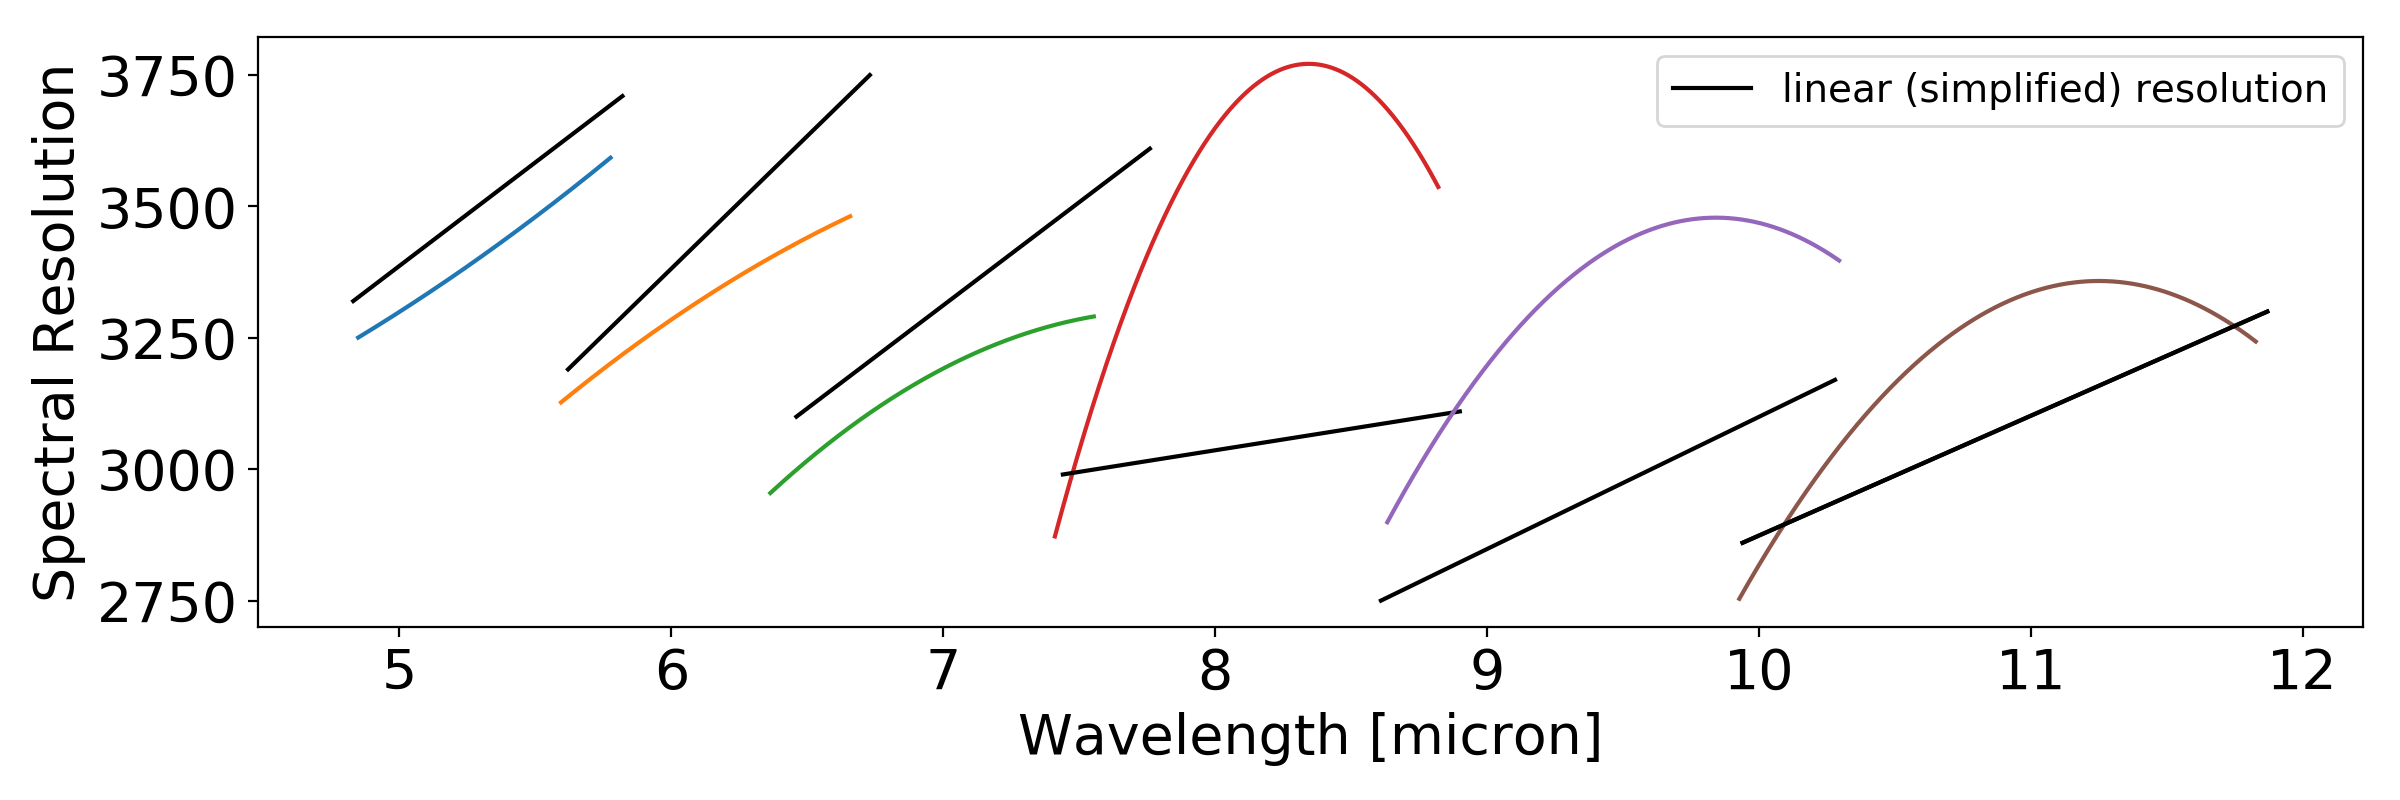

<IPython.core.display.Javascript object>


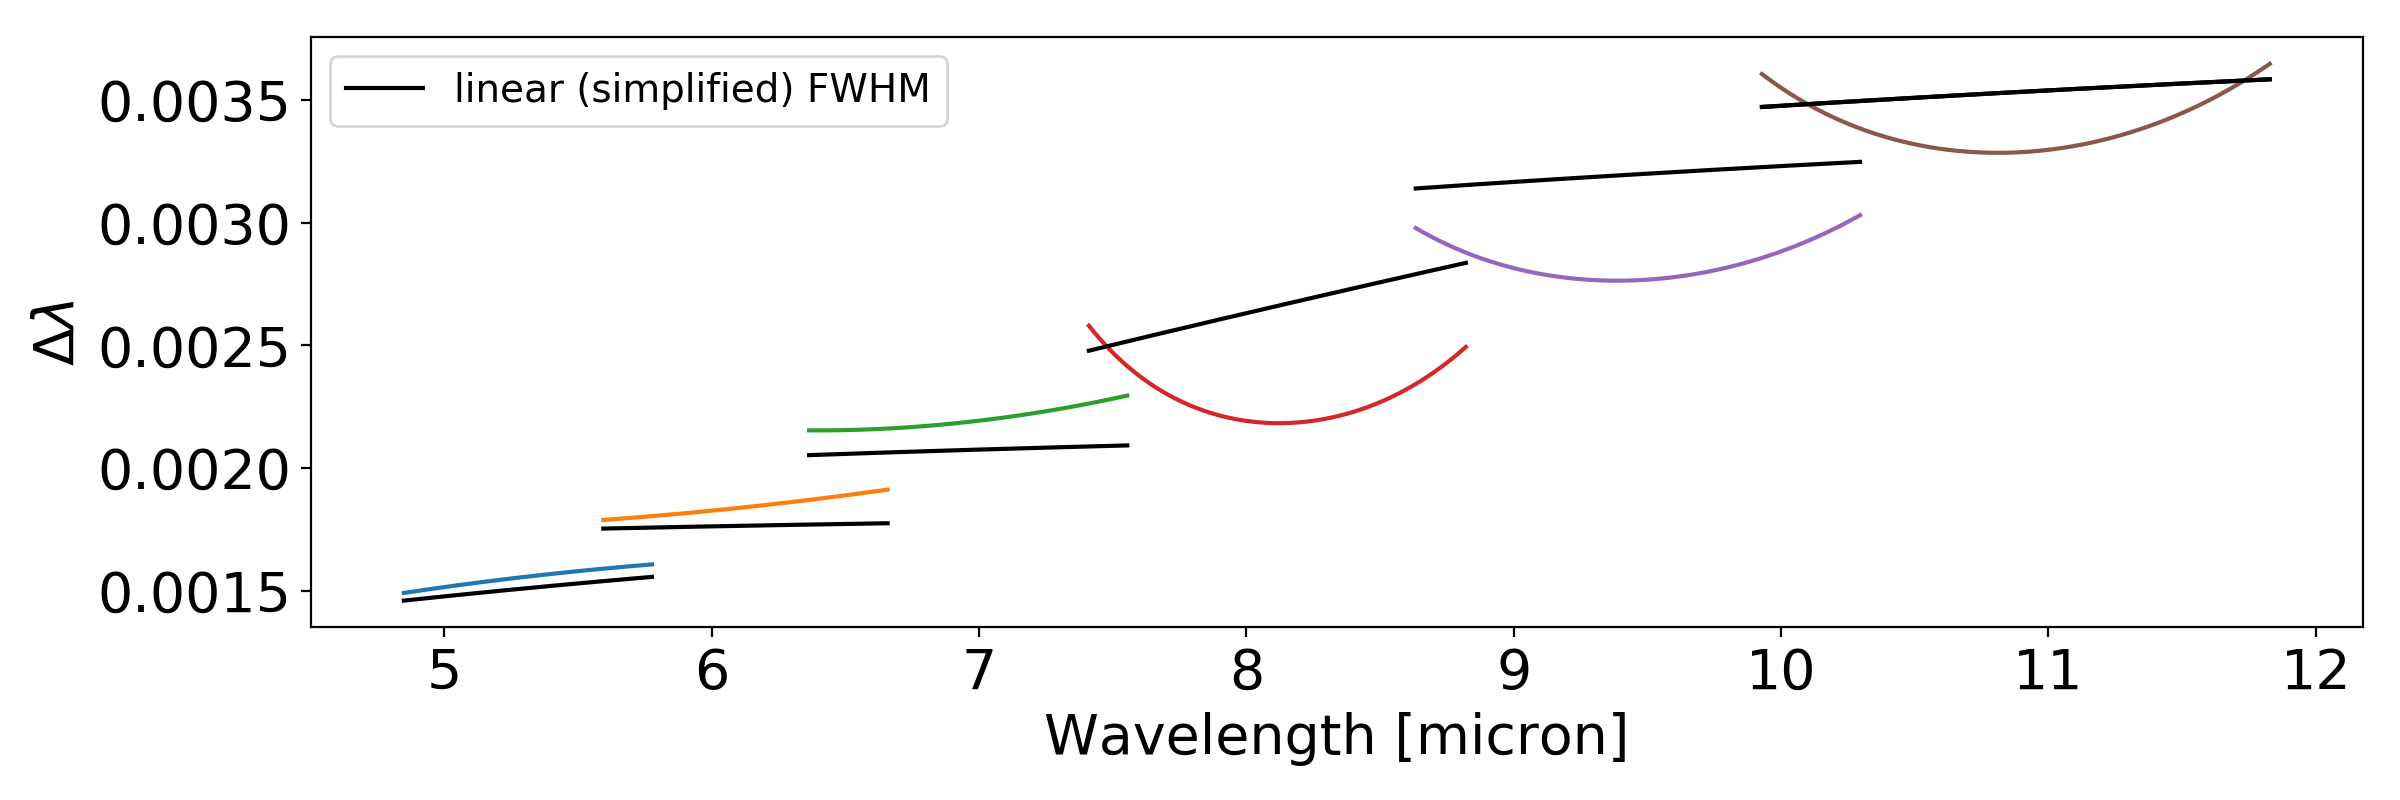

In [12]:
bands = ['1A','1B','1C','2A','2B','2C']
lambda_centers,lambda_fwhms,spec_res,linear_spec_res = {},{},{},{}
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]
    
    # construct spectral grid
    lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
    lambcens,lambfwhms = lambcens[1:],lambfwhms[1:]
    # derive spectral resolution
    Res = np.zeros(len(lambcens))
    for ibin in range(len(lambcens)):
        Res[ibin] = funcs.getSpecR(lamb0=lambcens[ibin],band=band,specres_table=specres_table)
    MRS_R_interp = interp1d(np.array([lambcens[0],lambcens[-1]]),np.array([ funcs.mrs_aux(band)[4][0],funcs.mrs_aux(band)[4][1] ]))
    
    # save output
    lambda_centers[band] = lambcens
    lambda_fwhms[band] = lambfwhms
    spec_res[band] = Res
    linear_spec_res[band] = MRS_R_interp(lambda_centers[band])

plt.figure(figsize=(12,4))
for band in bands:
    plt.plot(lambda_centers[band],spec_res[band])
    plt.plot(np.array([funcs.mrs_aux(band)[3][0],funcs.mrs_aux(band)[3][1]]),np.array([ funcs.mrs_aux(band)[4][0],funcs.mrs_aux(band)[4][1] ]),'k' )
plt.plot(np.array([funcs.mrs_aux(band)[3][0],funcs.mrs_aux(band)[3][1]]),np.array([ funcs.mrs_aux(band)[4][0],funcs.mrs_aux(band)[4][1] ]),'k',label='linear (simplified) resolution')
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Spectral Resolution',fontsize=20)
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
for band in bands:
    plt.plot(lambda_centers[band],lambda_centers[band]/spec_res[band])
    plt.plot(lambda_centers[band],lambda_centers[band]/linear_spec_res[band],'k')
plt.plot(lambda_centers[band],lambda_centers[band]/linear_spec_res[band],'k',label='linear (simplified) FWHM')
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('$\Delta \lambda$ [micron]',fontsize=20)
plt.legend(loc='upper left')
plt.tight_layout()

<IPython.core.display.Javascript object>


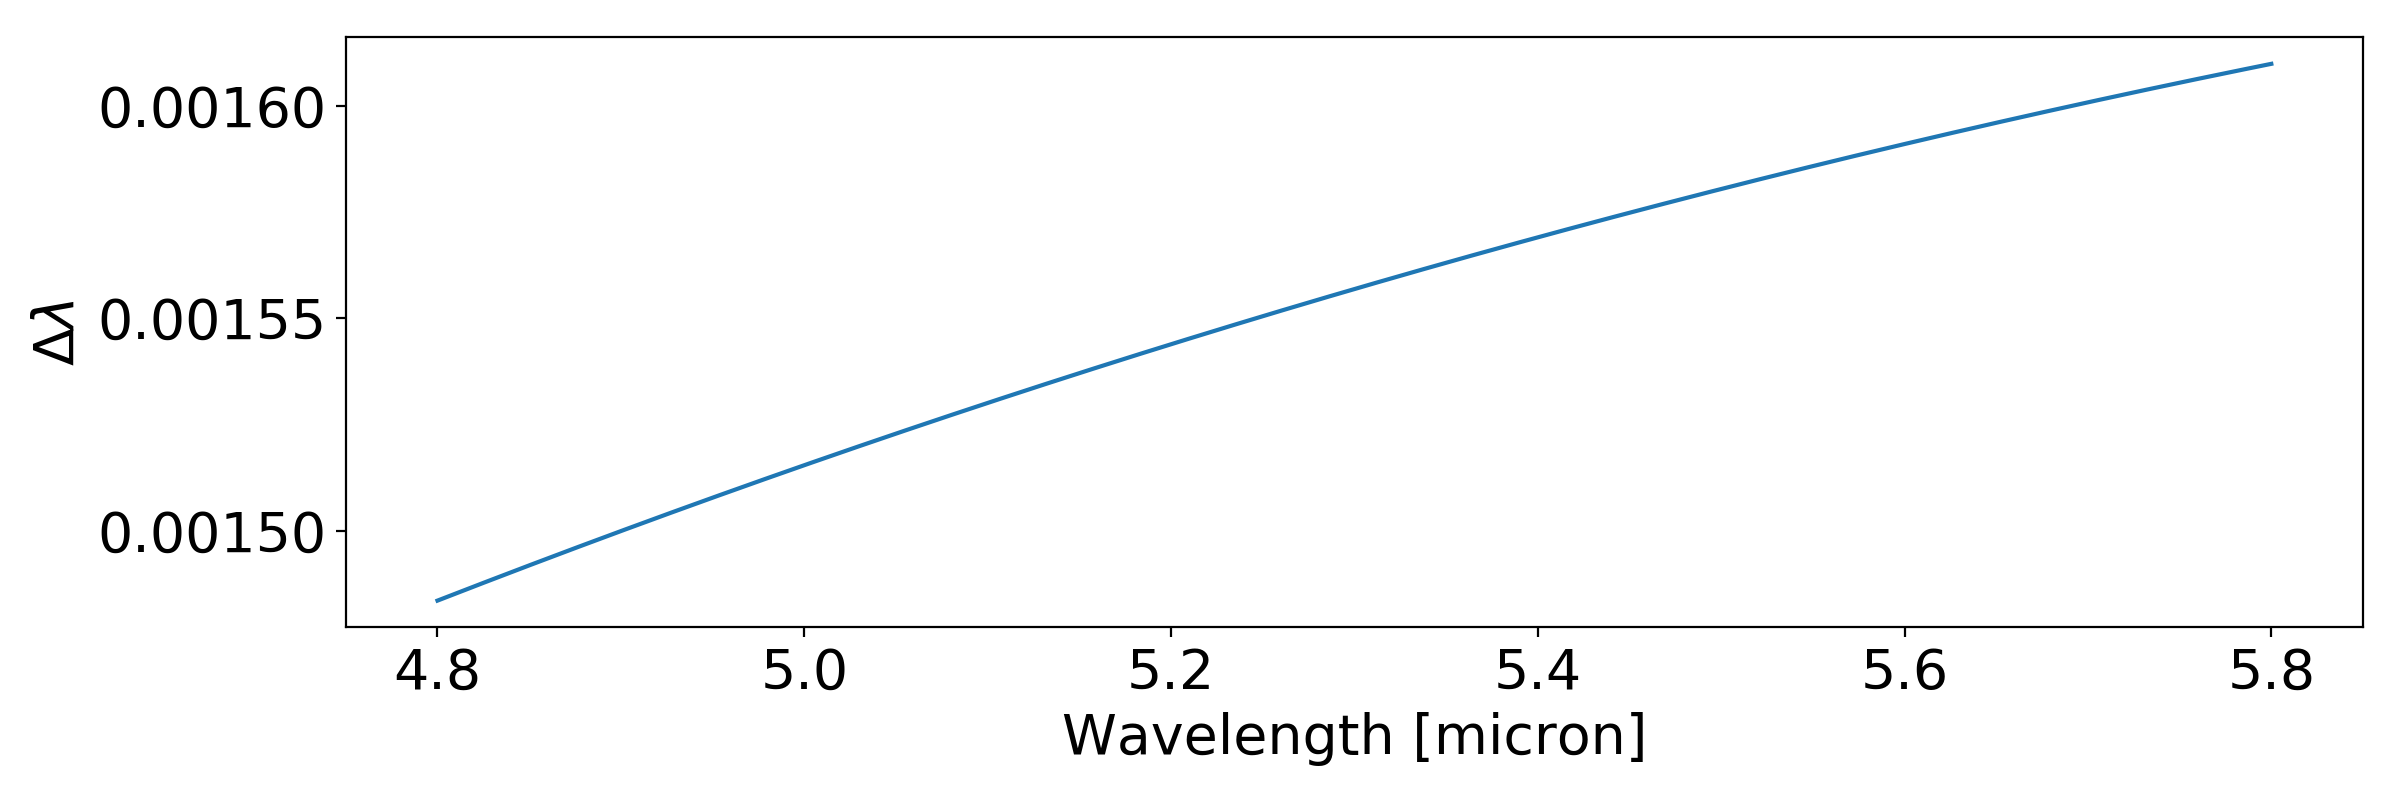

In [13]:
lamb_fwhms = {}
for band in bands:
    arr_interpolator = InterpolatedUnivariateSpline(lambda_centers[band],lambda_centers[band]/spec_res[band],k=3,ext=0)
    lamb_fwhms[band] = arr_interpolator(wav[band])

plt.figure(figsize=(12,4))
for band in ['1A']:
    plt.plot(wav[band],lamb_fwhms[band])
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('$\Delta \lambda$ [micron]',fontsize=20)
plt.legend(loc='upper left')
plt.tight_layout()

<IPython.core.display.Javascript object>


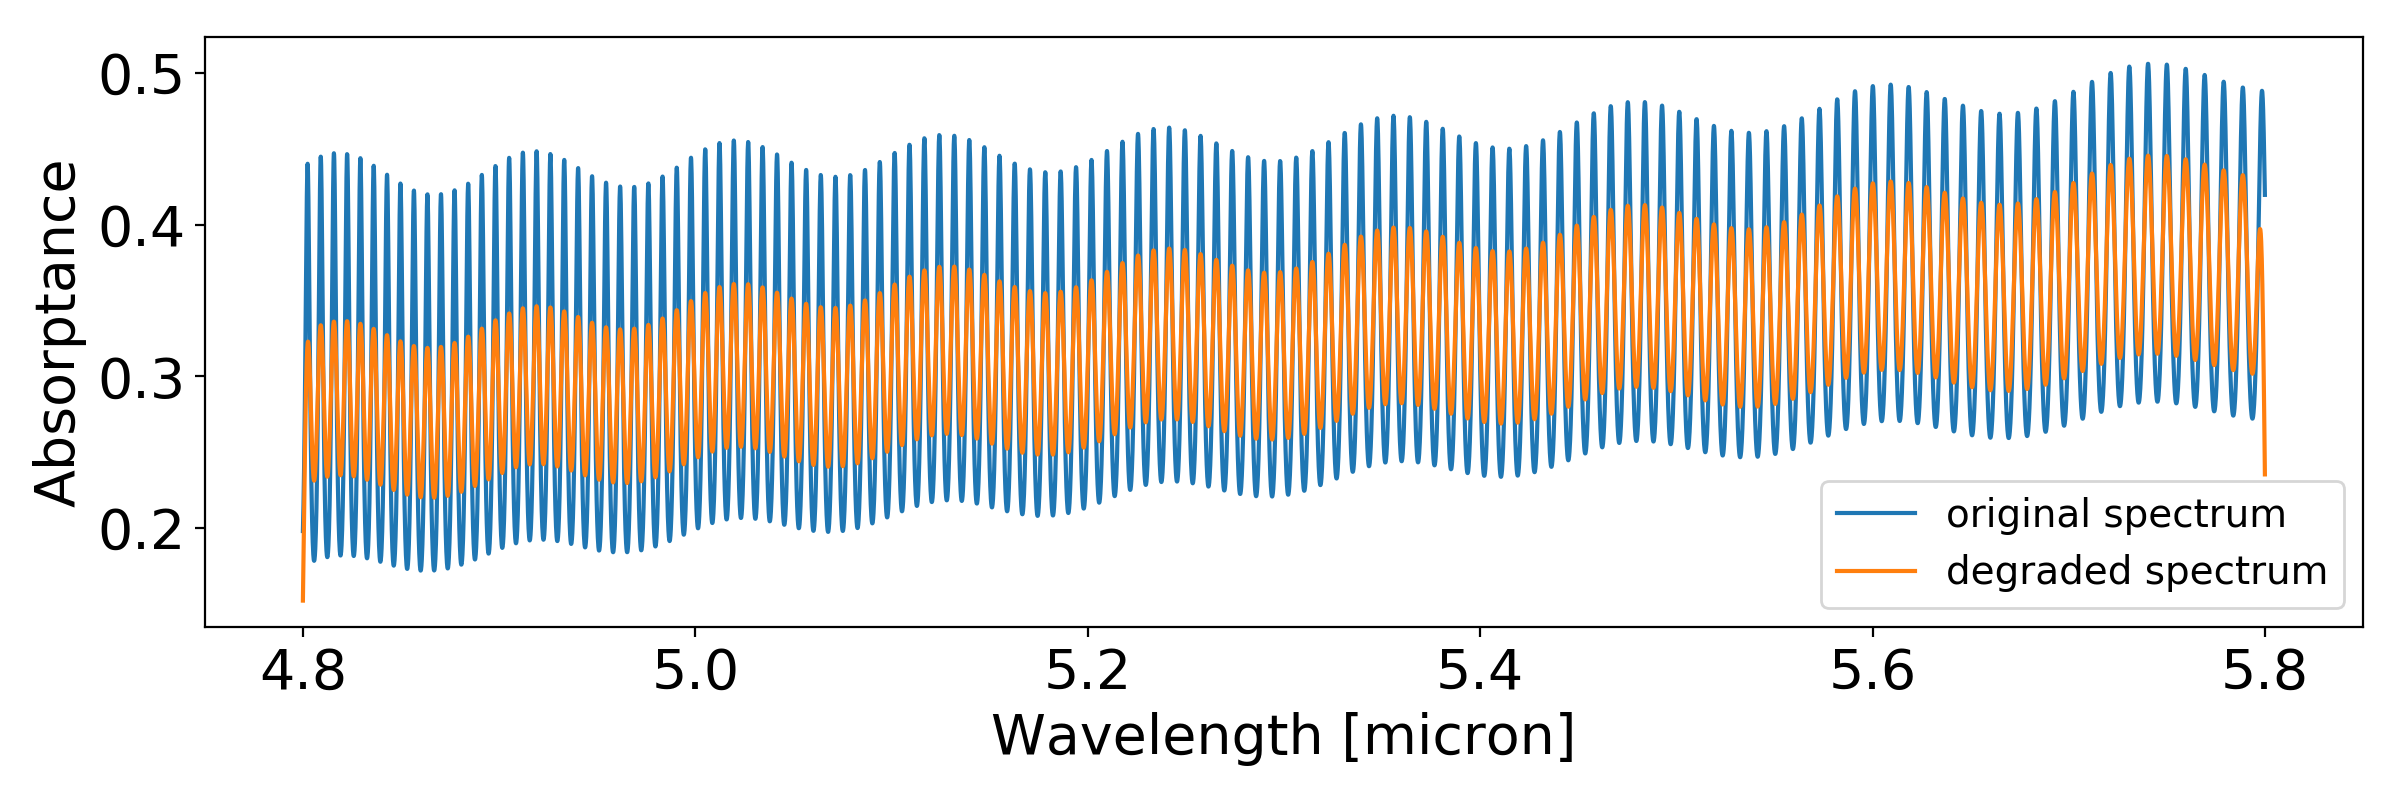

In [22]:
# degr_Refl,degr_Transm,degr_Absorp = {},{},{}
# for band in ['1A']:
#     degr_Absorp[band] = np.zeros(len(wav[band]))
#     for i in range(len(wav[band])):
#         degraded_spectrum = funcs.convolvegauss_windt(wav[band],Absorp[band],lamb_fwhms[band][i])
#         degr_Absorp[band][i] = degraded_spectrum[i]

plt.figure(figsize=(12,4))
plt.plot(wav[band],Absorp[band],label='original spectrum')
plt.plot(wav[band],degr_Absorp[band],label='degraded spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Absorptance')
plt.legend(loc='lower right')
plt.tight_layout()

<IPython.core.display.Javascript object>


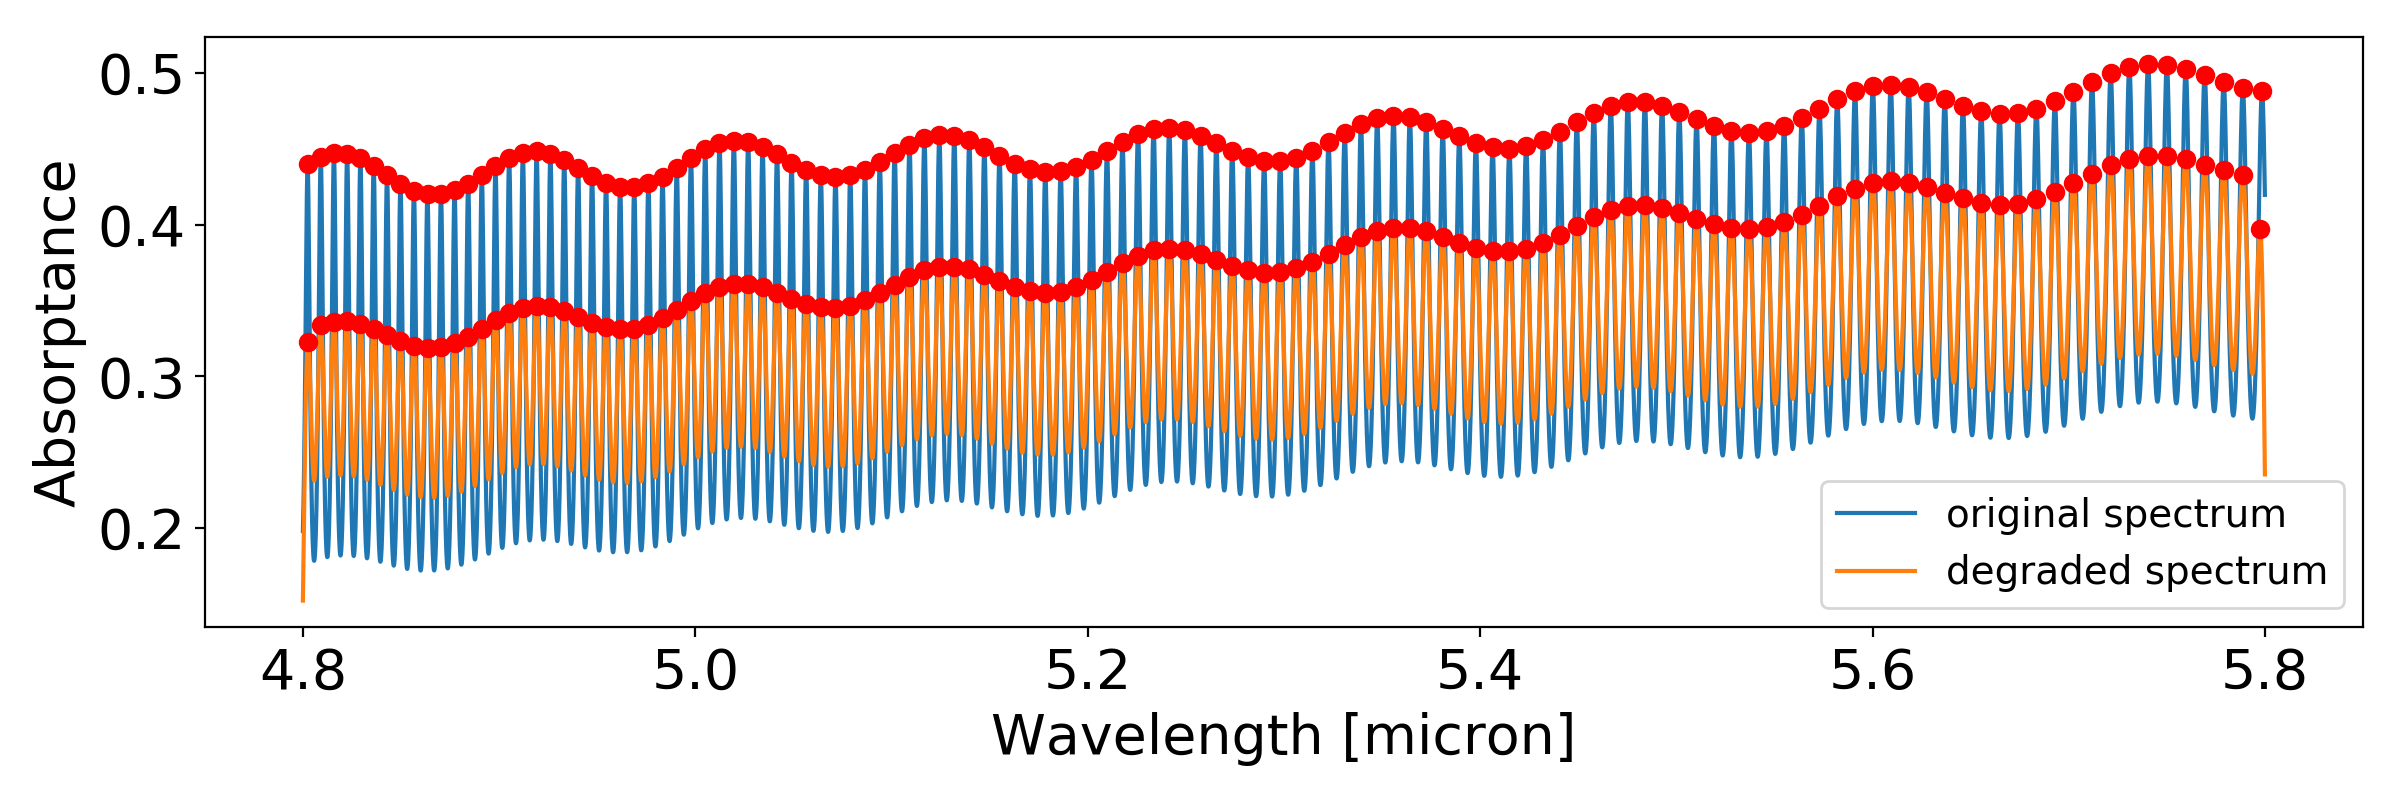

<IPython.core.display.Javascript object>


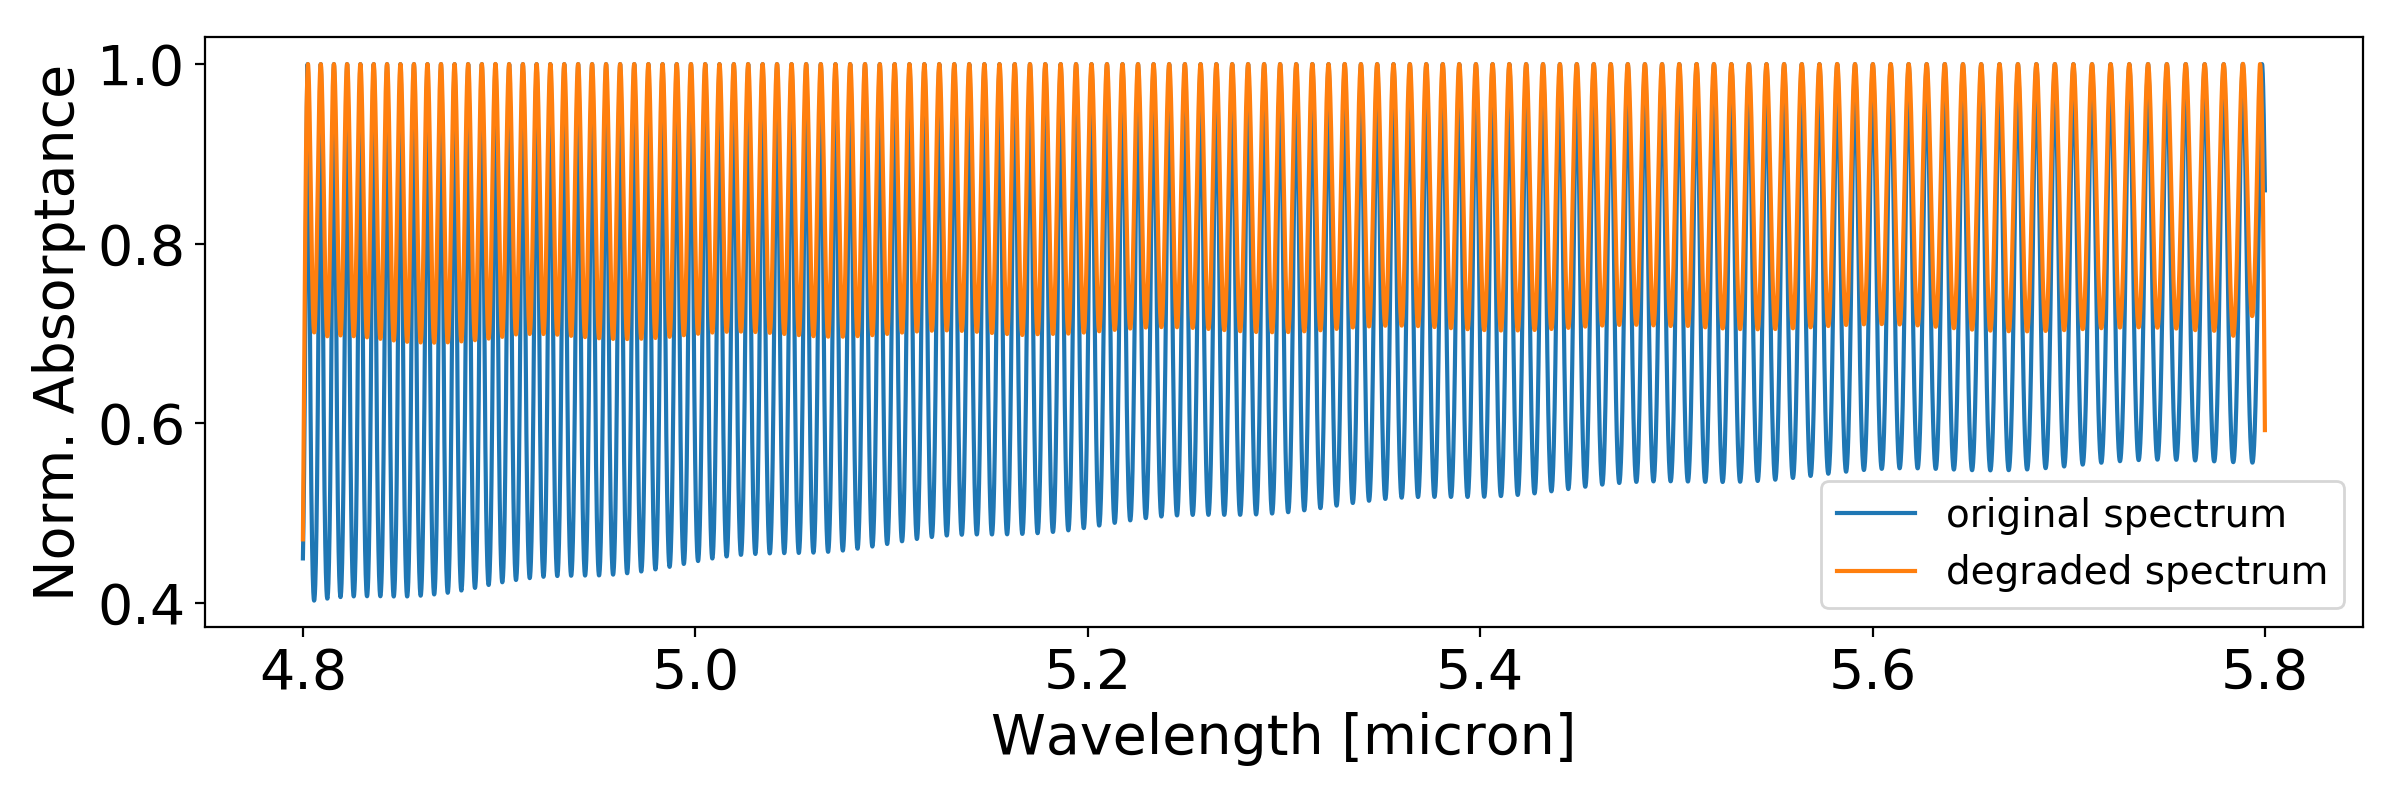

In [27]:
Absorp_norm = funcs.norm_fringe(Absorp[band],thres=0,min_dist=50,k=3,ext=3)
degr_Absorp_norm = funcs.norm_fringe(degr_Absorp[band],thres=0,min_dist=50,k=3,ext=3)

plt.figure(figsize=(12,4))
plt.plot(wav[band],Absorp_norm[0],label='original spectrum')
plt.plot(wav[band][Absorp_norm[1]],Absorp_norm[0][Absorp_norm[1]],'ro')
plt.plot(wav[band],degr_Absorp_norm[0],label='degraded spectrum')
plt.plot(wav[band][degr_Absorp_norm[1]],degr_Absorp_norm[0][degr_Absorp_norm[1]],'ro')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Absorptance')
plt.legend(loc='lower right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(wav[band],Absorp_norm[0]/Absorp_norm[2],label='original spectrum')
plt.plot(wav[band],degr_Absorp_norm[0]/degr_Absorp_norm[2],label='degraded spectrum')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Norm. Absorptance')
plt.legend(loc='lower right')
plt.tight_layout()

### Remarks:
* As expected the fringe contrast reduces with larger sigma (smaller spectral resolving power). (For the sake of clarity,) we also notice that the fringe peaks do not move w.r.t. their original positions.

What happens when jumping from one spectral resolution to another? (e.g. going from MRS band 1A, to band 1B)

<IPython.core.display.Javascript object>


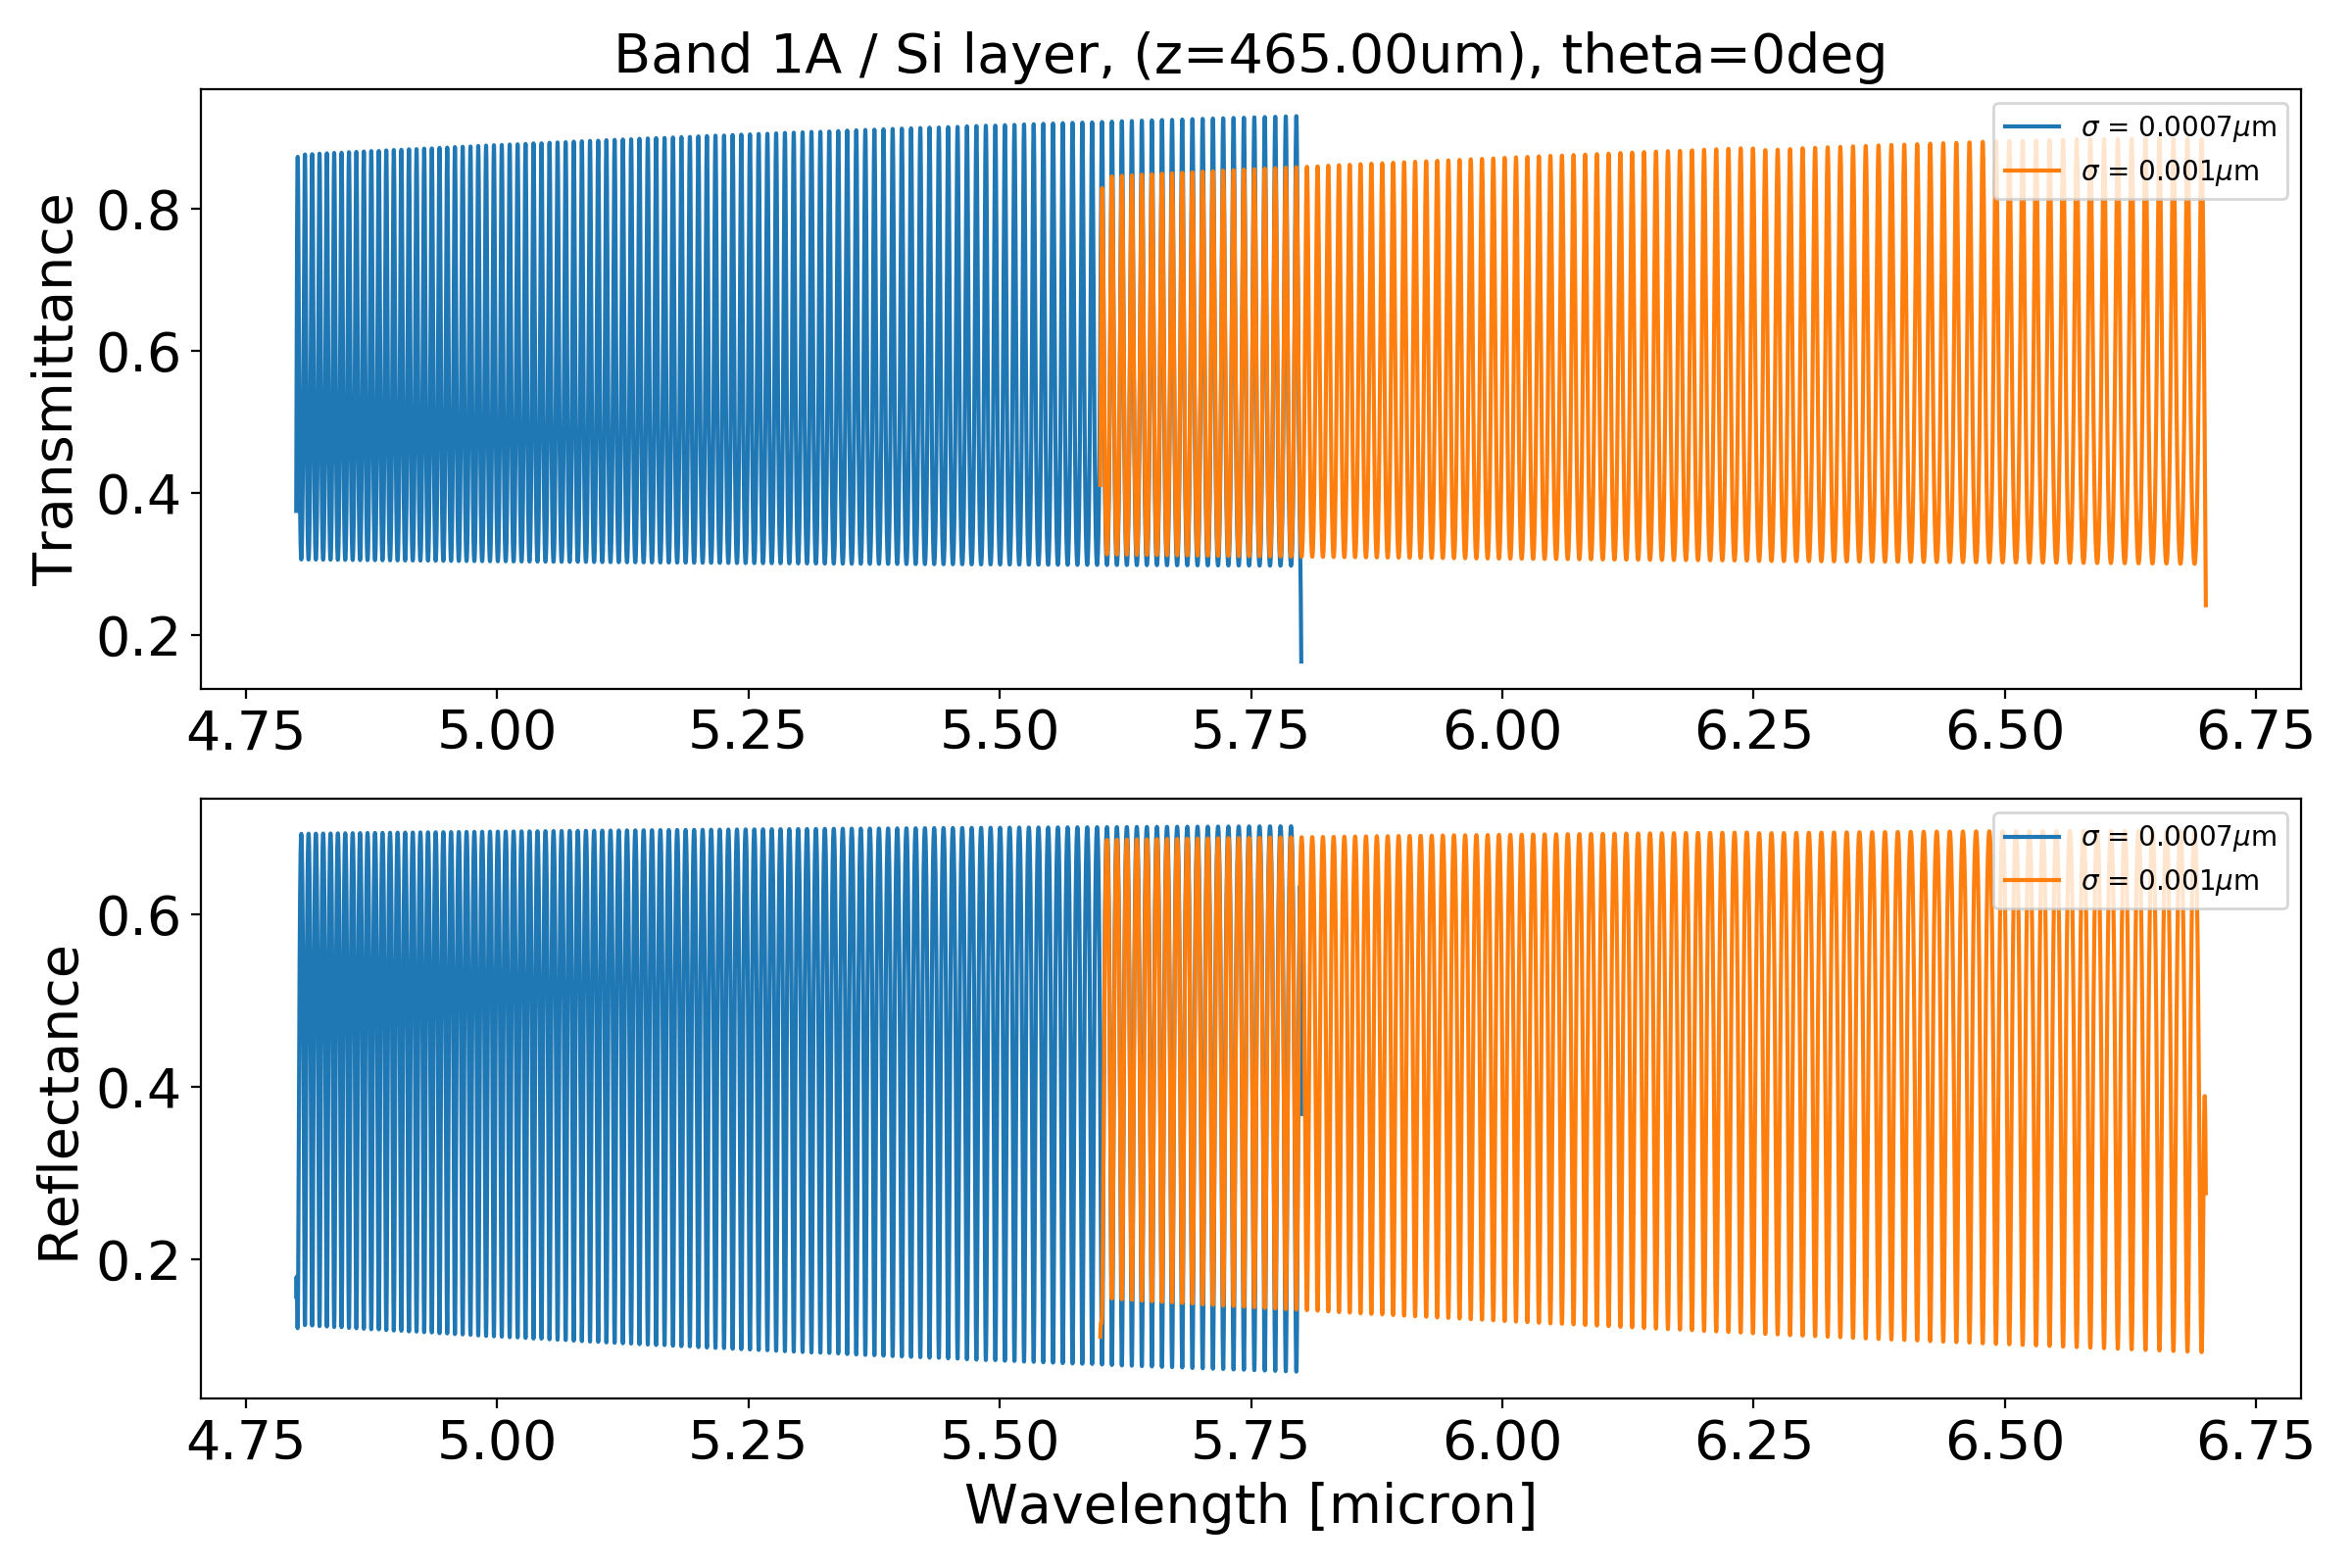

In [15]:
plt.close('all')
setup = 'Band {} / Si layer, (z=465.00um), theta=0deg'.format(band)
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].set_title(setup)
axs[0].plot(wav['1A'],funcs.convolvegauss_windt(wav['1A'],Transm['1A'],0.000666),label='$\sigma$ = 0.0007$\mu$m')
axs[0].plot(wav['1B'],funcs.convolvegauss_windt(wav['1B'],Transm['1B'],0.001068),label='$\sigma$ = 0.001$\mu$m')
axs[0].set_ylabel('Transmittance')
axs[0].legend(loc='upper right',fontsize=10)
axs[1].plot(wav['1A'],funcs.convolvegauss_windt(wav['1A'],Refl['1A'],0.000666),label='$\sigma$ = 0.0007$\mu$m')
axs[1].plot(wav['1B'],funcs.convolvegauss_windt(wav['1B'],Refl['1B'],0.001068),label='$\sigma$ = 0.001$\mu$m')
axs[1].set_xlabel('Wavelength [micron]')
axs[1].set_ylabel('Reflectance')
axs[1].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* A jump in spectral resolution leads to a predictable discontinuity in the fringe contrast.